In [1]:
#tool1
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wiki_wrapper=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [2]:
#tool2
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

arx_wrapper=ArxivAPIWrapper(top_k_results=3,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=arx_wrapper)

In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [5]:
#Tavili Search Tool(basically for google search)
from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

C:\Users\HARNISHA\AppData\Local\Temp\ipykernel_41088\112934120.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [6]:
tavily.invoke("Give me latest tech news")

[{'title': 'August 2025 - The Tech News Source',
  'url': 'https://thetechnewssource.com/2025/08/',
  'content': '# The Tech News Source\n\n## \n\n# Month: August 2025\n\n# Google Unveils AI-Centric Pixel 10, Watch 4 Amidst Launch Event Critique [...] Google has officially revealed its latest hardware lineup, featuring the Pixel 10 series, Pixel Watch 4, and updated Pixel Buds, all deeply integrated with advanced artificial intelligence. While the new devices introduce significant technological leaps, including a powerful new Tensor G5 chip and enhanced AI capabilities across the board, the presentation itself proved to be a notable point of contention for many viewers due to its unconventional format and hosting. The keynote, hosted by [...] The past two weeks in the tech world witnessed a rapid expansion of Artificial Intelligence (AI) capabilities across diverse products, revealing both extraordinary potential and significant inherent flaws. This period highlighted AI’s dual nature 

In [7]:
#combining all tools in a list
all_tools=[arxiv,wiki,tavily]

In [8]:
#initialize the LLM Model
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [9]:
llm.invoke("What is llm?")

AIMessage(content='<think>\n\n</think>\n\nLLM stands for **Large Language Model**. It refers to a type of artificial intelligence (AI) designed to understand and generate human language at a large scale. These models are trained on vast amounts of text data, allowing them to learn patterns, relationships, and structures within language. \n\nLarge Language Models are typically based on transformer architecture, which is particularly effective for processing sequential data like text. They are used for a wide range of tasks, including:\n\n1. **Text Generation**: Creating coherent and contextually relevant text based on a prompt.\n2. **Translation**: Translating text from one language to another.\n3. **Summarization**: Summarizing long pieces of text into concise versions.\n4. **Question Answering**: Providing answers to questions based on the content of a document or context.\n5. **Conversational AI**: Engaging in natural-sounding conversations with users.\n\nExamples of well-known LLMs 

In [10]:
#combining tools with llm
llm_and_tools=llm.bind_tools(tools=all_tools)

In [11]:
llm_and_tools.invoke("What is the recent movie in india?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, I need to figure out the recent movies released in India. Since I\'m not up-to-date on the latest Bollywood releases, I\'ll use the available tools to find this information.\n\nFirst, I consider using the "tavily_search_results_json" tool because it\'s designed for current events and comprehensive search results. It\'s likely to provide the most recent information on movie releases.\n\nI decide to make a function call with the query "recent movies in India 2023." This should fetch the latest data from reliable sources. \n\nAfter making the call, I receive a list of movies. From the results, I identify the most recent ones and compile a list of titles along with their release dates to provide a clear answer.\n', 'tool_calls': [{'id': '0hhvfabcx', 'function': {'arguments': '{"query":"recent movies in India 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'compl

In [12]:
#Workflow
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage #Human/AI Message
from typing import Annotated #labelling
from langgraph.graph.message import add_messages #reducers in langgraph

In [13]:
#State Schema
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages] #appends Human and AI messages without overriding messages

In [14]:
#Entire Chatbot With LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
 

In [15]:
#Creating Nodes
def tool_calling_llm(state:State):
    return{"messages":[llm_and_tools.invoke(state["messages"])]} #which tool is invoked is sent in the value

#adding the nodes 
graph=StateGraph(State)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools",ToolNode(tools=all_tools))


In [16]:
#adding the edges
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    #if tool is called routes to tools
    #if tool not called , routes to END
    tools_condition,    
)
graph.add_edge("tools",END)


In [17]:
#Compile the graph
graph_builder=graph.compile()

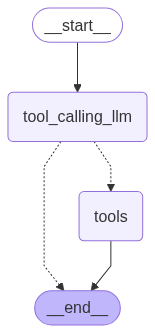

In [18]:
#view
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [19]:
messages=graph_builder.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (vw3ka88d7)
 Call ID: vw3ka88d7
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [20]:
messages=graph_builder.invoke({"messages":"Hey! I am Harnisha"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hey! I am Harnisha
================================== Ai Message ==================================

Hello, Harnisha! How can I assist you today?
